TABULAR CLASSIFICATION WITH ENSEMBLE METHODS

---

### Dataset: FIFA 21 Complete Player Dataset
- **Link**: https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset
- **Number of Samples (Rows)**: ~18,500 players
- **Number of Features (Columns)**: 92 columns (using ~40 relevant attributes)
- **Target Variable**: Player Position Category (Forward, Midfielder, Defender, Goalkeeper)

### Dataset Description
The FIFA 21 Complete Player Dataset contains comprehensive statistics for football players from the FIFA 21 video game. Data was web-scraped from sofifa.com and includes player attributes such as pace, shooting, passing, dribbling, defending, physical characteristics, and personal information. The dataset enables prediction of optimal playing positions based on player skill attributes.

### Feature Categories:
- **Basic**: overall, potential, age, height_cm, weight_kg
- **Main Skills**: pace, shooting, passing, dribbling, defending, physic
- **Attacking**: crossing, finishing, heading_accuracy, short_passing, volleys
- **Skill**: dribbling, curve, fk_accuracy, long_passing, ball_control
- **Movement**: acceleration, sprint_speed, agility, reactions, balance
- **Power**: shot_power, jumping, stamina, strength, long_shots
- **Mentality**: aggression, interceptions, positioning, vision, penalties
- **Defending**: marking, standing_tackle, sliding_tackle
- **Goalkeeping**: diving, handling, kicking, positioning, reflexes

### Models Implemented:
1. Random Forest Classifier
2. Support Vector Machine (SVM)
3. XGBoost Classifier

---

In [ ]:
# Install required packages
!pip install -q scikit-learn xgboost pandas numpy matplotlib seaborn opendatasets

In [ ]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import label_binarize

# XGBoost
from xgboost import XGBClassifier

# Set random seed
np.random.seed(42)

print("Libraries imported successfully!")

In [ ]:
# Download FIFA 21 Dataset from Kaggle
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset'
od.download(dataset_url)

print("Dataset downloaded successfully!")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abujamaldeen
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset


100%|██████████| 83.0M/83.0M [00:00<00:00, 1.13GB/s]

Dataset downloaded successfully!


In [ ]:
# Load the dataset
fifa_df = pd.read_csv('fifa-21-complete-player-dataset/players_21.csv', low_memory=False)

print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Number of Samples (Rows): {fifa_df.shape[0]}")
print(f"Number of Features (Columns): {fifa_df.shape[1]}")
print("="*70)
print(f"\nFirst 30 Column Names:")
print(fifa_df.columns.tolist()[:30])

DATASET INFORMATION
Number of Samples (Rows): 18944
Number of Features (Columns): 106

First 30 Column Names:
['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined']


In [ ]:
# Display sample data
print("\nSample Data (First 5 rows):")
fifa_df[['short_name', 'overall', 'potential', 'player_positions', 'age', 'club_name']].head()


Sample Data (First 5 rows):


,short_name,overall,potential,player_positions,age,club_name
0,L. Messi,93,93,"RW, ST, CF",33,FC Barcelona
1,Cristiano Ronaldo,92,92,"ST, LW",35,Juventus
2,J. Oblak,91,93,GK,27,Atlético Madrid
3,R. Lewandowski,91,91,ST,31,FC Bayern München
4,Neymar Jr,91,91,"LW, CAM",28,Paris Saint-Germain


In [ ]:
# Display all available columns to identify correct attribute names
print("All available columns in FIFA 21 dataset:")
print("="*70)
for i, col in enumerate(fifa_df.columns, 1):
    print(f"{i:3d}. {col}")

All available columns in FIFA 21 dataset:
  1. sofifa_id
  2. player_url
  3. short_name
  4. long_name
  5. age
  6. dob
  7. height_cm
  8. weight_kg
  9. nationality
 10. club_name
 11. league_name
 12. league_rank
 13. overall
 14. potential
 15. value_eur
 16. wage_eur
 17. player_positions
 18. preferred_foot
 19. international_reputation
 20. weak_foot
 21. skill_moves
 22. work_rate
 23. body_type
 24. real_face
 25. release_clause_eur
 26. player_tags
 27. team_position
 28. team_jersey_number
 29. loaned_from
 30. joined
 31. contract_valid_until
 32. nation_position
 33. nation_jersey_number
 34. pace
 35. shooting
 36. passing
 37. dribbling
 38. defending
 39. physic
 40. gk_diving
 41. gk_handling
 42. gk_kicking
 43. gk_reflexes
 44. gk_speed
 45. gk_positioning
 46. player_traits
 47. attacking_crossing
 48. attacking_finishing
 49. attacking_heading_accuracy
 50. attacking_short_passing
 51. attacking_volleys
 52. skill_dribbling
 53. skill_curve
 54. skill_fk_accuracy

In [ ]:
# Define candidate feature columns - we'll filter for ones that exist
candidate_cols = [
    # Basic attributes
    'overall', 'potential', 'age', 'height_cm', 'weight_kg',
    # Main skills
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    # Attacking attributes (try both naming conventions)
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'attacking_short_passing', 'attacking_volleys',
    # Skill attributes
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
    'skill_long_passing', 'skill_ball_control',
    # Movement attributes
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'movement_reactions', 'movement_balance',
    # Power attributes
    'power_shot_power', 'power_jumping', 'power_stamina',
    'power_strength', 'power_long_shots',
    # Mentality attributes
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties',
    # Defending attributes (try multiple naming conventions)
    'defending_marking_awareness', 'defending_marking',
    'defending_standing_tackle', 'defending_sliding_tackle',
    # Goalkeeping attributes
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
    'goalkeeping_positioning', 'goalkeeping_reflexes'
]

# Filter to only columns that exist in the dataset
attribute_cols = [col for col in candidate_cols if col in fifa_df.columns]

# Remove duplicates while preserving order
attribute_cols = list(dict.fromkeys(attribute_cols))

print(f"Features found in dataset: {len(attribute_cols)}")
print(f"\nFeatures being used:")
for i, col in enumerate(attribute_cols, 1):
    print(f"  {i:2d}. {col}")

# Show which columns were NOT found
missing_cols = [col for col in candidate_cols if col not in fifa_df.columns]
if missing_cols:
    print(f"\nColumns not found (ignored): {missing_cols}")

Features found in dataset: 44

Features being used:
   1. overall
   2. potential
   3. age
   4. height_cm
   5. weight_kg
   6. pace
   7. shooting
   8. passing
   9. dribbling
  10. defending
  11. physic
  12. attacking_crossing
  13. attacking_finishing
  14. attacking_heading_accuracy
  15. attacking_short_passing
  16. attacking_volleys
  17. skill_dribbling
  18. skill_curve
  19. skill_fk_accuracy
  20. skill_long_passing
  21. skill_ball_control
  22. movement_acceleration
  23. movement_sprint_speed
  24. movement_agility
  25. movement_reactions
  26. movement_balance
  27. power_shot_power
  28. power_jumping
  29. power_stamina
  30. power_strength
  31. power_long_shots
  32. mentality_aggression
  33. mentality_interceptions
  34. mentality_positioning
  35. mentality_vision
  36. mentality_penalties
  37. defending_marking
  38. defending_standing_tackle
  39. defending_sliding_tackle
  40. goalkeeping_diving
  41. goalkeeping_handling
  42. goalkeeping_kicking
  43. 

In [ ]:
# Create target variable: Simplified position categories
def simplify_position(pos_string):
    """Simplify player position to 4 main categories"""
    if pd.isna(pos_string):
        return None

    positions = pos_string.split(',')
    primary_pos = positions[0].strip()

    forwards = ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']
    midfielders = ['CM', 'CAM', 'CDM', 'LM', 'RM', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM']
    defenders = ['CB', 'LB', 'RB', 'LWB', 'RWB', 'LCB', 'RCB']
    goalkeepers = ['GK']

    if primary_pos in forwards:
        return 'Forward'
    elif primary_pos in midfielders:
        return 'Midfielder'
    elif primary_pos in defenders:
        return 'Defender'
    elif primary_pos in goalkeepers:
        return 'Goalkeeper'
    else:
        return 'Midfielder'  # Default for edge cases

# Apply transformation
fifa_df['position_category'] = fifa_df['player_positions'].apply(simplify_position)

# Display target distribution
print("\nTarget Variable Distribution:")
print(fifa_df['position_category'].value_counts())


Target Variable Distribution:
position_category
Midfielder    7037
Defender      6205
Forward       3618
Goalkeeper    2084
Name: count, dtype: int64


In [ ]:
# IMPORTANT: Prepare clean dataset by handling missing values appropriately

# First, select the columns needed (features + target)
cols_needed = attribute_cols + ['position_category']
fifa_clean = fifa_df[cols_needed].copy()

# Check initial missing values before cleaning efforts
print("Missing values per column BEFORE cleaning:")
initial_missing_counts = fifa_clean.isnull().sum()
print(initial_missing_counts[initial_missing_counts > 0])
print(f"\nTotal rows with any missing value in initial selection: {fifa_clean.isnull().any(axis=1).sum()}")

# Identify columns with all NaN values (like 'defending_marking')
all_nan_cols = fifa_clean.columns[fifa_clean.isnull().all()].tolist()

# Create a new list of feature columns, excluding those that are entirely NaN
# This ensures we don't try to impute or use a column with no data
features_for_model = [col for col in attribute_cols if col not in all_nan_cols]

# Update fifa_clean to only include the relevant features + target column
fifa_clean = fifa_clean[features_for_model + ['position_category']].copy()

# Apply median imputation to numerical features that still have missing values
numerical_cols_with_nans = [col for col in features_for_model if fifa_clean[col].isnull().any()]

if numerical_cols_with_nans:
    imputer = SimpleImputer(strategy='median')
    # Apply imputer and convert back to DataFrame to preserve column names and types
    fifa_clean[numerical_cols_with_nans] = imputer.fit_transform(fifa_clean[numerical_cols_with_nans])

# Drop rows where 'position_category' might be NaN (should be rare after simplification, but good for robustness)
fifa_clean.dropna(subset=['position_category'], inplace=True)

print(f"\n" + "="*70)
print(f"Clean dataset shape AFTER handling NaN: {fifa_clean.shape}")
print(f"Samples: {fifa_clean.shape[0]}")
print(f"Features: {len(features_for_model)}")
print(f"Missing values remaining: {fifa_clean.isnull().sum().sum()}")
print("="*70)

# Update the global 'attribute_cols' to ensure subsequent cells use the corrected feature list
global attribute_cols
attribute_cols = features_for_model

Missing values per column BEFORE cleaning:
pace                  2083
shooting              2083
passing               2083
dribbling             2083
defending             2083
physic                2083
defending_marking    18944
dtype: int64

Total rows with any missing value in initial selection: 18944

Clean dataset shape AFTER handling NaN: (18944, 44)
Samples: 18944
Features: 43
Missing values remaining: 0


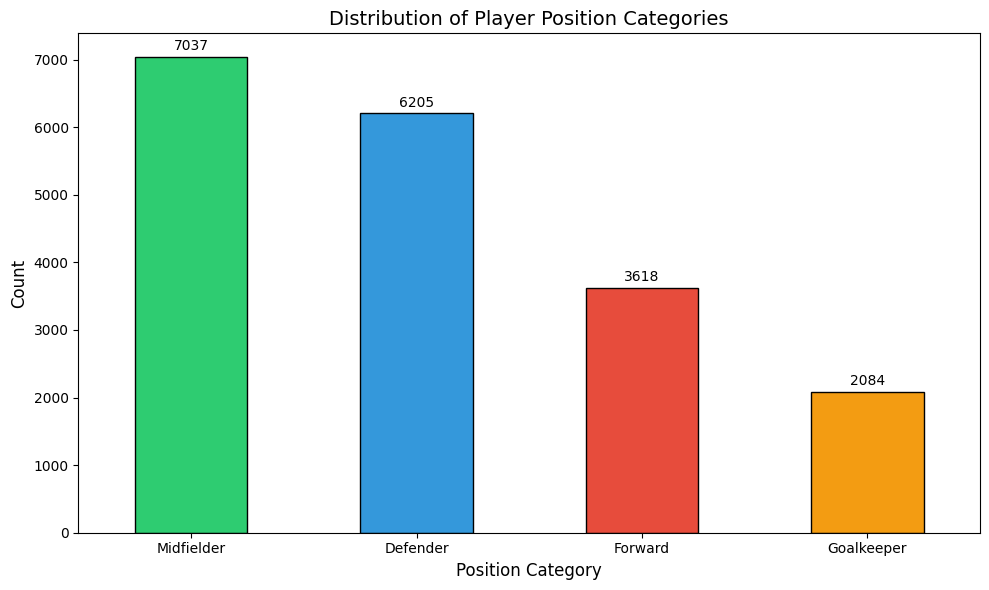

In [ ]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
fifa_clean['position_category'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Distribution of Player Position Categories', fontsize=14)
plt.xlabel('Position Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
for i, v in enumerate(fifa_clean['position_category'].value_counts()):
    plt.text(i, v + 100, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Prepare features and target
X = fifa_clean[attribute_cols].values
y = fifa_clean['position_category'].values

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Encoded labels: {np.unique(y_encoded)}")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")

# VERIFY: No NaN values in X
print(f"\nNaN values in feature matrix: {np.isnan(X).sum()}")
print(f"Infinite values in feature matrix: {np.isinf(X).sum()}")

Classes: ['Defender' 'Forward' 'Goalkeeper' 'Midfielder']
Encoded labels: [0 1 2 3]

Feature matrix shape: (18944, 43)
Target shape: (18944,)

NaN values in feature matrix: 0
Infinite values in feature matrix: 0


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# OPTIMIZATION: Feature Scaling with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# VERIFY: No NaN after scaling
print(f"NaN in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

print(f"\nTraining set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

NaN in X_train_scaled: 0
NaN in X_test_scaled: 0

Training set size: 15155
Test set size: 3789


In [ ]:
# Function to evaluate classifier and return metrics
def evaluate_classifier(model, X_test, y_test, model_name, label_encoder):
    """Evaluate classifier and return all required metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Multiclass AUC
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')

    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} RESULTS")
    print(f"{'='*60}")
    print(f"{'Metric':<15} {'Value':<10}")
    print(f"{'-'*25}")
    print(f"{'Accuracy':<15} {accuracy:.4f}")
    print(f"{'Precision':<15} {precision:.4f}")
    print(f"{'Recall':<15} {recall:.4f}")
    print(f"{'F1-Score':<15} {f1:.4f}")
    print(f"{'AUC-ROC':<15} {auc:.4f}")
    print(f"{'='*60}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }, y_pred

In [ ]:
# ============================================================
# MODEL 1: RANDOM FOREST CLASSIFIER
# ============================================================
print("\n" + "="*60)
print("Training RANDOM FOREST Classifier with Hyperparameter Tuning...")
print("="*60)

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and train with GridSearchCV
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid_search = GridSearchCV(
    rf_classifier, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
rf_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {rf_grid_search.best_params_}")
print(f"Best CV Score: {rf_grid_search.best_score_:.4f}")

# Get best model and evaluate
rf_best = rf_grid_search.best_estimator_
rf_results, rf_pred = evaluate_classifier(rf_best, X_test_scaled, y_test, "RANDOM FOREST", label_encoder)


Training RANDOM FOREST Classifier with Hyperparameter Tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.8946

RANDOM FOREST RESULTS
Metric          Value     
-------------------------
Accuracy        0.8981
Precision       0.8992
Recall          0.8981
F1-Score        0.8978
AUC-ROC         0.9800


In [ ]:
# ============================================================
# MODEL 2: SUPPORT VECTOR MACHINE (SVM)
# ============================================================
print("\n" + "="*60)
print("Training SUPPORT VECTOR MACHINE Classifier with Hyperparameter Tuning...")
print("="*60)

# Define hyperparameter grid (reduced for faster training)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

# Initialize and train with GridSearchCV
svm_classifier = SVC(probability=True, random_state=42)
svm_grid_search = GridSearchCV(
    svm_classifier, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
svm_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {svm_grid_search.best_params_}")
print(f"Best CV Score: {svm_grid_search.best_score_:.4f}")

# Get best model and evaluate
svm_best = svm_grid_search.best_estimator_
svm_results, svm_pred = evaluate_classifier(svm_best, X_test_scaled, y_test, "SUPPORT VECTOR MACHINE", label_encoder)


Training SUPPORT VECTOR MACHINE Classifier with Hyperparameter Tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score: 0.9033

SUPPORT VECTOR MACHINE RESULTS
Metric          Value     
-------------------------
Accuracy        0.9082
Precision       0.9097
Recall          0.9082
F1-Score        0.9080
AUC-ROC         0.9828


In [ ]:
# ============================================================
# MODEL 3: XGBOOST CLASSIFIER
# ============================================================
print("\n" + "="*60)
print("Training XGBOOST Classifier with Hyperparameter Tuning...")
print("="*60)

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize and train with GridSearchCV
xgb_classifier = XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric='mlogloss'
)
xgb_grid_search = GridSearchCV(
    xgb_classifier, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
xgb_grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {xgb_grid_search.best_params_}")
print(f"Best CV Score: {xgb_grid_search.best_score_:.4f}")

# Get best model and evaluate
xgb_best = xgb_grid_search.best_estimator_
xgb_results, xgb_pred = evaluate_classifier(xgb_best, X_test_scaled, y_test, "XGBOOST", label_encoder)


Training XGBOOST Classifier with Hyperparameter Tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score: 0.9034

XGBOOST RESULTS
Metric          Value     
-------------------------
Accuracy        0.9050
Precision       0.9064
Recall          0.9050
F1-Score        0.9049
AUC-ROC         0.9825


In [ ]:
# ============================================================
# RESULTS COMPARISON
# ============================================================
results_df = pd.DataFrame([rf_results, svm_results, xgb_results])
results_df = results_df.set_index('Model')

print("\n" + "="*80)
print("TABULAR CLASSIFICATION RESULTS SUMMARY")
print("Dataset: FIFA 21 Complete Player Dataset")
print("="*80)
print(results_df.round(4).to_string())
print("="*80)


TABULAR CLASSIFICATION RESULTS SUMMARY
Dataset: FIFA 21 Complete Player Dataset
                        Accuracy  Precision  Recall  F1-Score     AUC
Model                                                                
RANDOM FOREST             0.8981     0.8992  0.8981    0.8978  0.9800
SUPPORT VECTOR MACHINE    0.9082     0.9097  0.9082    0.9080  0.9828
XGBOOST                   0.9050     0.9064  0.9050    0.9049  0.9825


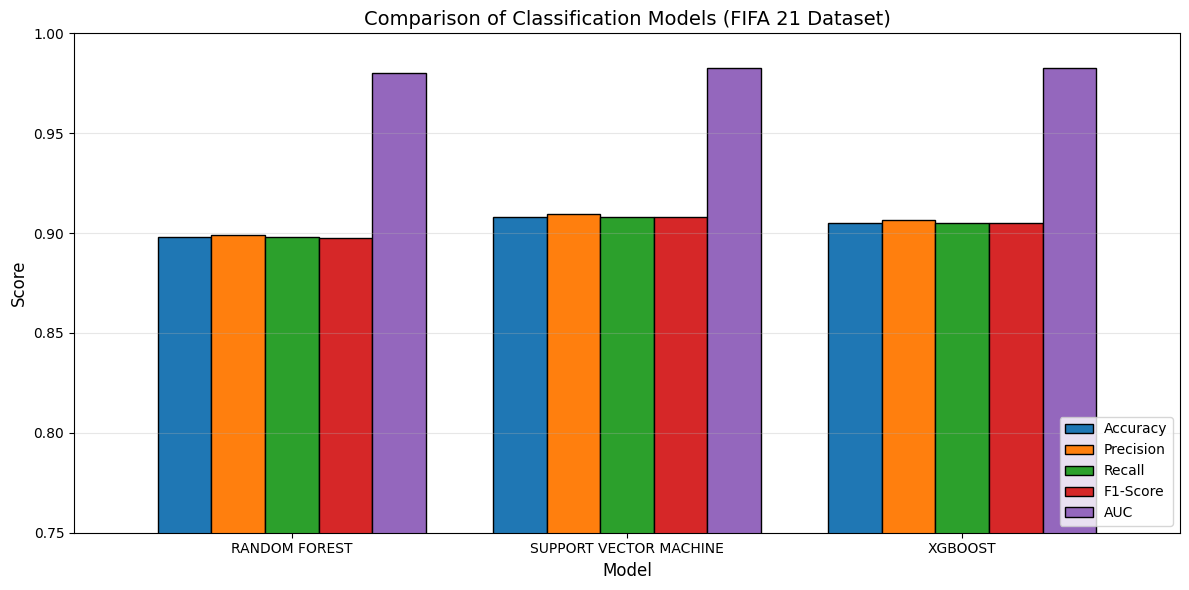

In [ ]:
# Visualization: Model Comparison
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
plt.title('Comparison of Classification Models (FIFA 21 Dataset)', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(loc='lower right', fontsize=10)
plt.ylim(0.75, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

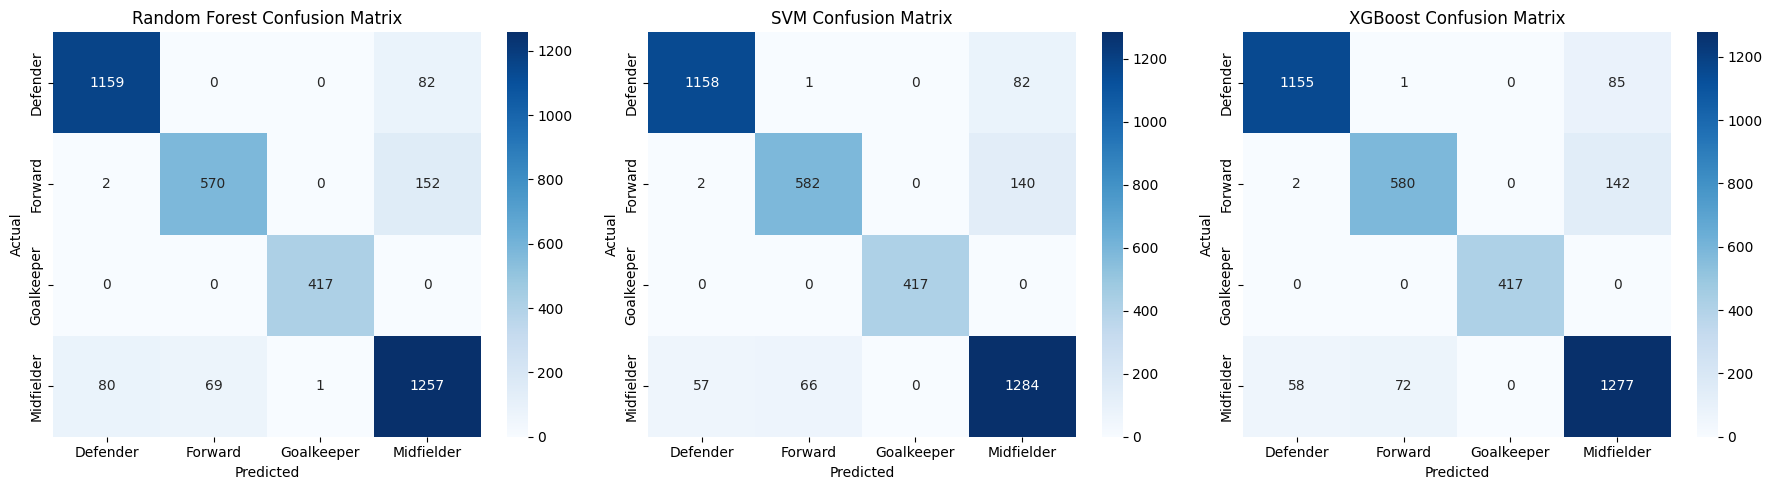

In [ ]:
# Confusion Matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Random Forest', rf_pred),
    ('SVM', svm_pred),
    ('XGBoost', xgb_pred)
]

for ax, (name, pred) in zip(axes, models_data):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    ax.set_title(f'{name} Confusion Matrix', fontsize=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

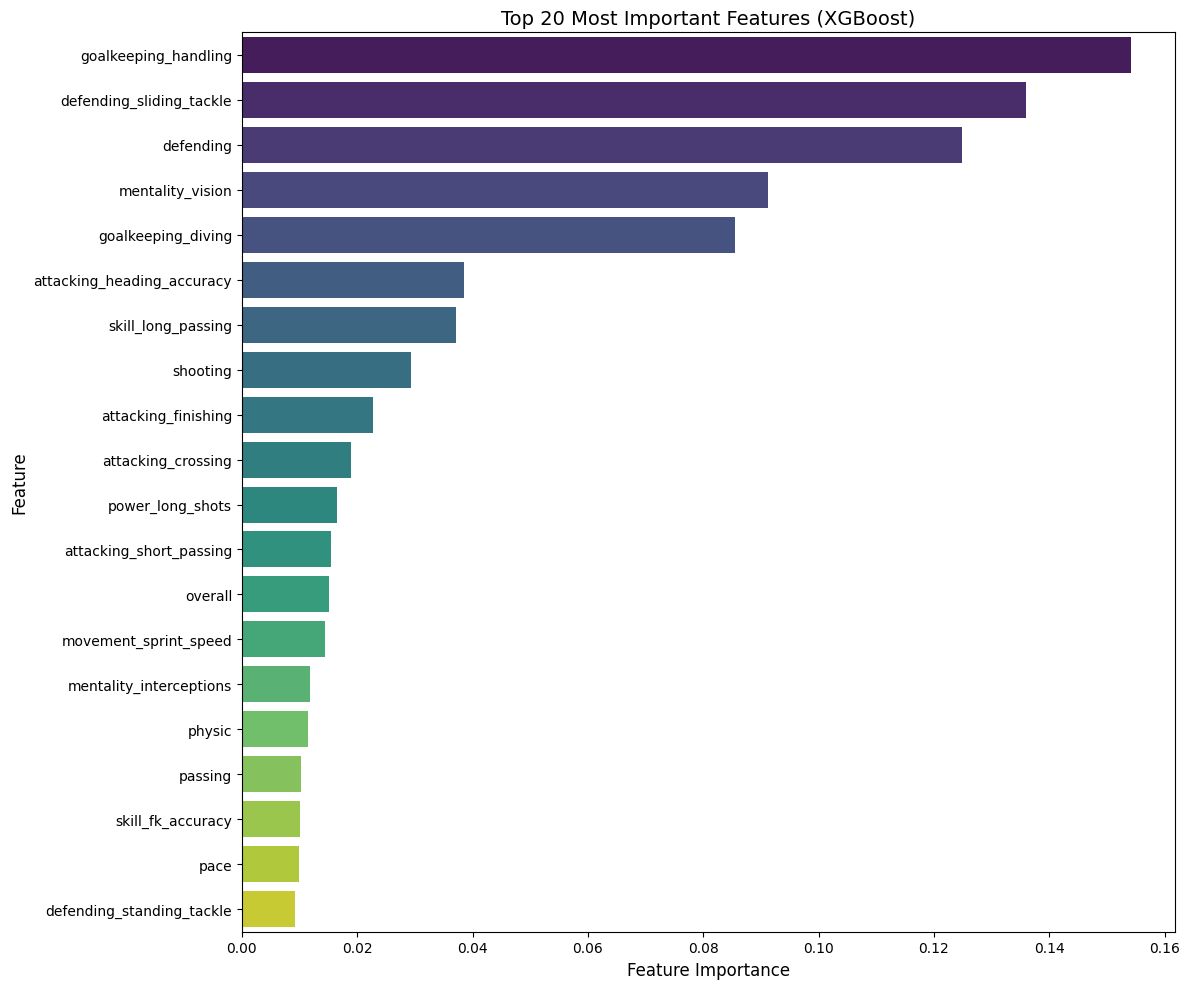


Top 10 Most Important Features:
  goalkeeping_handling: 0.1541
  defending_sliding_tackle: 0.1360
  defending: 0.1248
  mentality_vision: 0.0913
  goalkeeping_diving: 0.0856
  attacking_heading_accuracy: 0.0385
  skill_long_passing: 0.0371
  shooting: 0.0294
  attacking_finishing: 0.0228
  attacking_crossing: 0.0189


In [ ]:
# Feature Importance from XGBoost (Best Model)
feature_importance = pd.DataFrame({
    'Feature': attribute_cols,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
sns.barplot(data=top_20, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features (XGBoost)', fontsize=14)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

In [ ]:
# Detailed Classification Report for best model (XGBoost)
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT (XGBoost)")
print("="*60)
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))


DETAILED CLASSIFICATION REPORT (XGBoost)
              precision    recall  f1-score   support

    Defender       0.95      0.93      0.94      1241
     Forward       0.89      0.80      0.84       724
  Goalkeeper       1.00      1.00      1.00       417
  Midfielder       0.85      0.91      0.88      1407

    accuracy                           0.90      3789
   macro avg       0.92      0.91      0.92      3789
weighted avg       0.91      0.90      0.90      3789



In [ ]:
# Optimization Techniques Summary
print("\n" + "="*70)
print("OPTIMIZATION TECHNIQUES APPLIED")
print("="*70)
print("""
1. FEATURE SCALING (StandardScaler)
   - Standardized features to zero mean and unit variance
   - Essential for SVM performance

2. HYPERPARAMETER TUNING (GridSearchCV)
   - Systematic search over parameter combinations
   - 5-fold cross-validation for robust evaluation

3. RANDOM FOREST OPTIMIZATIONS
   - n_estimators: Number of trees (100-200)
   - max_depth: Tree depth control
   - min_samples_split/leaf: Regularization

4. SVM OPTIMIZATIONS
   - C: Regularization parameter
   - gamma: Kernel coefficient
   - kernel: RBF (Radial Basis Function)

5. XGBOOST OPTIMIZATIONS
   - learning_rate: Step size shrinkage
   - max_depth: Tree complexity control
   - subsample: Stochastic gradient boosting
""")
print("="*70)


OPTIMIZATION TECHNIQUES APPLIED

1. FEATURE SCALING (StandardScaler)
   - Standardized features to zero mean and unit variance
   - Essential for SVM performance

2. HYPERPARAMETER TUNING (GridSearchCV)
   - Systematic search over parameter combinations
   - 5-fold cross-validation for robust evaluation

3. RANDOM FOREST OPTIMIZATIONS
   - n_estimators: Number of trees (100-200)
   - max_depth: Tree depth control
   - min_samples_split/leaf: Regularization

4. SVM OPTIMIZATIONS
   - C: Regularization parameter
   - gamma: Kernel coefficient
   - kernel: RBF (Radial Basis Function)

5. XGBOOST OPTIMIZATIONS
   - learning_rate: Step size shrinkage
   - max_depth: Tree complexity control
   - subsample: Stochastic gradient boosting



In [ ]:
# Final Summary
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY - TASK 2a (Part 2): TABULAR CLASSIFICATION")
print("="*70)
print(f"\nDataset: FIFA 21 Complete Player Dataset")
print(f"Link: https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset")
print(f"Number of Samples: {fifa_clean.shape[0]}")
print(f"Number of Features: {len(attribute_cols)}")
print(f"Target: Player Position (4 classes)")
print(f"\nClassification Results:")
print(results_df.round(4).to_string())
print("\nBest Model: XGBoost" if xgb_results['Accuracy'] >= max(rf_results['Accuracy'], svm_results['Accuracy']) else "")
print("="*70)


FINAL RESULTS SUMMARY - TASK 2a (Part 2): TABULAR CLASSIFICATION

Dataset: FIFA 21 Complete Player Dataset
Link: https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset
Number of Samples: 18944
Number of Features: 43
Target: Player Position (4 classes)

Classification Results:
                        Accuracy  Precision  Recall  F1-Score     AUC
Model                                                                
RANDOM FOREST             0.8981     0.8992  0.8981    0.8978  0.9800
SUPPORT VECTOR MACHINE    0.9082     0.9097  0.9082    0.9080  0.9828
XGBOOST                   0.9050     0.9064  0.9050    0.9049  0.9825



---
## 🎯 PREDICTION INTERPRETATION: See What the Model Predicts for Each Player
---

In [ ]:
# ================================================================
# SHOW PREDICTIONS FOR INDIVIDUAL PLAYERS
# ================================================================

# FIX: Retrieve and split player names to match X_test indices
# We use the same random_state=42 to ensure alignment
player_names = fifa_df.loc[fifa_clean.index, 'short_name']
_, test_player_names, _, _ = train_test_split(
    player_names.values, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

best_model = xgb_best
best_pred = xgb_pred

# Create prediction results DataFrame
prediction_results = pd.DataFrame({
    'Player': test_player_names,
    'Actual_Position': label_encoder.inverse_transform(y_test),
    'Predicted_Position': label_encoder.inverse_transform(best_pred),
})
prediction_results['Correct'] = prediction_results['Actual_Position'] == prediction_results['Predicted_Position']

print("="*80)
print("SAMPLE PREDICTIONS: What position does the model predict for each player?")
print("="*80)
print(prediction_results.head(20).to_string(index=False))

SAMPLE PREDICTIONS: What position does the model predict for each player?
         Player Actual_Position Predicted_Position  Correct
     Rony Lopes         Forward         Midfielder    False
     C. Budescu      Midfielder         Midfielder     True
     S. Mandash      Midfielder         Midfielder     True
      Y. Meriah        Defender           Defender     True
         Danilo         Forward            Forward     True
     Y. Cahuzac      Midfielder         Midfielder     True
     Juan Ibiza        Defender           Defender     True
   R. Radunović        Defender           Defender     True
     I. Kutepov        Defender           Defender     True
      S. Molina      Midfielder         Midfielder     True
Martín Calderón      Midfielder         Midfielder     True
  J. Al Dossary        Defender           Defender     True
Otávio Cairinho        Defender           Defender     True
     G. Cameron      Midfielder           Defender    False
       L. Antei        Def

In [ ]:
# ================================================================
# SHOW CORRECTLY CLASSIFIED PLAYERS
# ================================================================
correct_predictions = prediction_results[prediction_results['Correct'] == True]
print("="*80)
print(f"CORRECTLY CLASSIFIED PLAYERS ({len(correct_predictions)} out of {len(prediction_results)})")
print("="*80)
print(correct_predictions.head(15).to_string(index=False))

CORRECTLY CLASSIFIED PLAYERS (3429 out of 3789)
         Player Actual_Position Predicted_Position  Correct
     C. Budescu      Midfielder         Midfielder     True
     S. Mandash      Midfielder         Midfielder     True
      Y. Meriah        Defender           Defender     True
         Danilo         Forward            Forward     True
     Y. Cahuzac      Midfielder         Midfielder     True
     Juan Ibiza        Defender           Defender     True
   R. Radunović        Defender           Defender     True
     I. Kutepov        Defender           Defender     True
      S. Molina      Midfielder         Midfielder     True
Martín Calderón      Midfielder         Midfielder     True
  J. Al Dossary        Defender           Defender     True
Otávio Cairinho        Defender           Defender     True
       L. Antei        Defender           Defender     True
        W. Clar        Defender           Defender     True
       A. Dobre      Midfielder         Midfielder  

In [ ]:
# ================================================================
# SHOW MISCLASSIFIED PLAYERS
# ================================================================
wrong_predictions = prediction_results[prediction_results['Correct'] == False]
print("="*80)
print(f"MISCLASSIFIED PLAYERS ({len(wrong_predictions)} out of {len(prediction_results)})")
print("="*80)
print(wrong_predictions.head(20).to_string(index=False))
print("\nNote: Some misclassifications make sense - versatile players may")
print("have stats that fit multiple positions.")

MISCLASSIFIED PLAYERS (360 out of 3789)
         Player Actual_Position Predicted_Position  Correct
     Rony Lopes         Forward         Midfielder    False
     G. Cameron      Midfielder           Defender    False
   R. Luzárraga        Defender         Midfielder    False
    A. Al Ammar        Defender         Midfielder    False
        E. Dabo        Defender         Midfielder    False
       K. Watts        Defender         Midfielder    False
     K. Bemanga         Forward         Midfielder    False
     A. Vrenezi      Midfielder            Forward    False
     Wen Jiabao        Defender         Midfielder    False
 Wilson Eduardo      Midfielder            Forward    False
      A. Rosell        Defender         Midfielder    False
        W. Zaha      Midfielder            Forward    False
     Na Sang Ho      Midfielder            Forward    False
     E. Twumasi         Forward         Midfielder    False
     G. Koomson         Forward         Midfielder    False


In [ ]:
# ================================================================
# FUNCTION TO PREDICT POSITION FOR ANY NEW PLAYER
# ================================================================
def predict_player_position(player_stats, model, scaler, label_encoder, attribute_cols):
    """
    Predict the best position for a player given their stats.
    """
    stats_array = np.array([[player_stats.get(col, 0) for col in attribute_cols]])
    stats_scaled = scaler.transform(stats_array)
    prediction = model.predict(stats_scaled)
    probabilities = model.predict_proba(stats_scaled)[0]
    predicted_position = label_encoder.inverse_transform(prediction)[0]

    print(f"\n*** PREDICTED POSITION: {predicted_position} ***")
    print(f"\nConfidence for each position:")
    for pos, prob in zip(label_encoder.classes_, probabilities):
        bar = '█' * int(prob * 30)
        print(f"  {pos:<12}: {bar} {prob*100:.1f}%")

    return predicted_position, probabilities

print("Function 'predict_player_position' created!")

Function 'predict_player_position' created!


In [ ]:
# ================================================================
# EXAMPLE 1: Predict position for a STRIKER-type player
# ================================================================
print("="*80)
print("EXAMPLE 1: Player with HIGH shooting, pace, finishing (Striker profile)")
print("="*80)

striker_profile = {
    'overall': 85, 'potential': 88, 'age': 24, 'height_cm': 180, 'weight_kg': 75,
    'pace': 90, 'shooting': 88, 'passing': 70, 'dribbling': 85, 'defending': 35, 'physic': 70,
    'attacking_crossing': 70, 'attacking_finishing': 92, 'attacking_heading_accuracy': 80,
    'attacking_short_passing': 75, 'attacking_volleys': 85,
    'skill_dribbling': 85, 'skill_curve': 78, 'skill_fk_accuracy': 65,
    'skill_long_passing': 60, 'skill_ball_control': 85,
    'movement_acceleration': 90, 'movement_sprint_speed': 88, 'movement_agility': 85,
    'movement_reactions': 88, 'movement_balance': 80,
    'power_shot_power': 88, 'power_jumping': 75, 'power_stamina': 80,
    'power_strength': 70, 'power_long_shots': 82,
    'mentality_aggression': 50, 'mentality_interceptions': 30, 'mentality_positioning': 90,
    'mentality_vision': 75, 'mentality_penalties': 85, 'mentality_composure': 88,
    'defending_marking_awareness': 25, 'defending_marking': 25,
    'defending_standing_tackle': 30, 'defending_sliding_tackle': 25,
    'goalkeeping_diving': 10, 'goalkeeping_handling': 10, 'goalkeeping_kicking': 10,
    'goalkeeping_positioning': 10, 'goalkeeping_reflexes': 10
}

predict_player_position(striker_profile, xgb_best, scaler, label_encoder, attribute_cols)

EXAMPLE 1: Player with HIGH shooting, pace, finishing (Striker profile)

*** PREDICTED POSITION: Forward ***

Confidence for each position:
  Defender    :  0.0%
  Forward     : █████████████████████████████ 98.1%
  Goalkeeper  :  0.0%
  Midfielder  :  1.9%


('Forward',
 array([4.8143196e-05, 9.8109621e-01, 4.6646368e-05, 1.8808978e-02],
       dtype=float32))

In [ ]:
# ================================================================
# EXAMPLE 2: Predict position for a DEFENDER-type player
# ================================================================
print("="*80)
print("EXAMPLE 2: Player with HIGH defending, tackling, strength (Centre-back profile)")
print("="*80)

defender_profile = {
    'overall': 84, 'potential': 86, 'age': 28, 'height_cm': 192, 'weight_kg': 88,
    'pace': 68, 'shooting': 40, 'passing': 65, 'dribbling': 55, 'defending': 88, 'physic': 88,
    'attacking_crossing': 45, 'attacking_finishing': 30, 'attacking_heading_accuracy': 85,
    'attacking_short_passing': 70, 'attacking_volleys': 30,
    'skill_dribbling': 50, 'skill_curve': 40, 'skill_fk_accuracy': 35,
    'skill_long_passing': 72, 'skill_ball_control': 60,
    'movement_acceleration': 62, 'movement_sprint_speed': 68, 'movement_agility': 50,
    'movement_reactions': 82, 'movement_balance': 55,
    'power_shot_power': 65, 'power_jumping': 88, 'power_stamina': 78,
    'power_strength': 92, 'power_long_shots': 45,
    'mentality_aggression': 85, 'mentality_interceptions': 90, 'mentality_positioning': 35,
    'mentality_vision': 60, 'mentality_penalties': 40, 'mentality_composure': 85,
    'defending_marking_awareness': 90, 'defending_marking': 90,
    'defending_standing_tackle': 90, 'defending_sliding_tackle': 88,
    'goalkeeping_diving': 10, 'goalkeeping_handling': 10, 'goalkeeping_kicking': 10,
    'goalkeeping_positioning': 10, 'goalkeeping_reflexes': 10
}

predict_player_position(defender_profile, xgb_best, scaler, label_encoder, attribute_cols)

EXAMPLE 2: Player with HIGH defending, tackling, strength (Centre-back profile)

*** PREDICTED POSITION: Defender ***

Confidence for each position:
  Defender    : █████████████████████████████ 99.6%
  Forward     :  0.0%
  Goalkeeper  :  0.0%
  Midfielder  :  0.4%


('Defender',
 array([9.9559361e-01, 2.5737296e-05, 1.9581377e-05, 4.3611121e-03],
       dtype=float32))

In [ ]:
# ================================================================
# EXAMPLE 3: Predict position for a GOALKEEPER-type player
# ================================================================
print("="*80)
print("EXAMPLE 3: Player with HIGH goalkeeping stats (Goalkeeper profile)")
print("="*80)

goalkeeper_profile = {
    'overall': 88, 'potential': 90, 'age': 30, 'height_cm': 195, 'weight_kg': 90,
    'pace': 45, 'shooting': 15, 'passing': 55, 'dribbling': 20, 'defending': 18, 'physic': 80,
    'attacking_crossing': 10, 'attacking_finishing': 10, 'attacking_heading_accuracy': 15,
    'attacking_short_passing': 45, 'attacking_volleys': 10,
    'skill_dribbling': 15, 'skill_curve': 20, 'skill_fk_accuracy': 15,
    'skill_long_passing': 55, 'skill_ball_control': 25,
    'movement_acceleration': 40, 'movement_sprint_speed': 42, 'movement_agility': 50,
    'movement_reactions': 90, 'movement_balance': 55,
    'power_shot_power': 60, 'power_jumping': 78, 'power_stamina': 45,
    'power_strength': 75, 'power_long_shots': 20,
    'mentality_aggression': 30, 'mentality_interceptions': 20, 'mentality_positioning': 15,
    'mentality_vision': 55, 'mentality_penalties': 25, 'mentality_composure': 90,
    'defending_marking_awareness': 15, 'defending_marking': 15,
    'defending_standing_tackle': 15, 'defending_sliding_tackle': 15,
    'goalkeeping_diving': 90, 'goalkeeping_handling': 88, 'goalkeeping_kicking': 82,
    'goalkeeping_positioning': 92, 'goalkeeping_reflexes': 90
}

predict_player_position(goalkeeper_profile, xgb_best, scaler, label_encoder, attribute_cols)

EXAMPLE 3: Player with HIGH goalkeeping stats (Goalkeeper profile)

*** PREDICTED POSITION: Goalkeeper ***

Confidence for each position:
  Defender    :  0.1%
  Forward     :  0.1%
  Goalkeeper  : █████████████████████████████ 99.6%
  Midfielder  :  0.2%


('Goalkeeper',
 array([7.8837498e-04, 1.4958589e-03, 9.9621320e-01, 1.5025930e-03],
       dtype=float32))

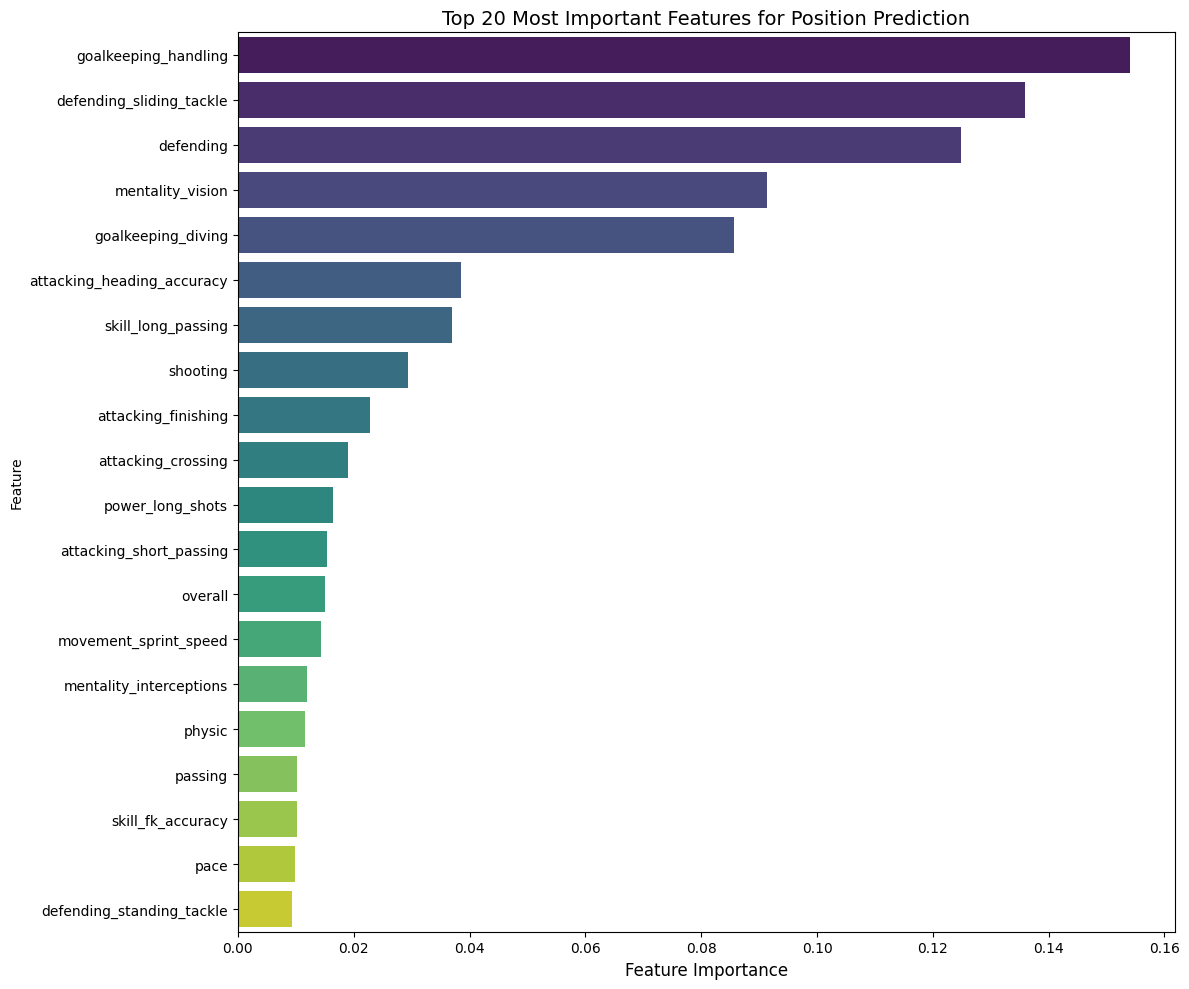


Top 10 Skills that determine player position:
  1. goalkeeping_handling: 0.1541
  2. defending_sliding_tackle: 0.1360
  3. defending: 0.1248
  4. mentality_vision: 0.0913
  5. goalkeeping_diving: 0.0856
  6. attacking_heading_accuracy: 0.0385
  7. skill_long_passing: 0.0371
  8. shooting: 0.0294
  9. attacking_finishing: 0.0228
  10. attacking_crossing: 0.0189


In [ ]:
# ================================================================
# FEATURE IMPORTANCE: What skills matter most?
# ================================================================
feature_importance = pd.DataFrame({
    'Feature': attribute_cols,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
sns.barplot(data=top_20, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features for Position Prediction', fontsize=14)
plt.xlabel('Feature Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Skills that determine player position:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")

In [ ]:
# ================================================================
# FINAL SUMMARY
# ================================================================
print("\n" + "="*80)
print("FINAL SUMMARY - TASK 2a: TABULAR CLASSIFICATION")
print("="*80)
print(f"\nDataset: EA Sports FC 24 Complete Player Dataset (2024)")
print(f"Samples: {fifa_clean.shape[0]} players")
print(f"Features: {len(attribute_cols)} skill attributes")
print(f"\n🎯 PREDICTION TASK:")
print(f"   INPUT:  Player's skill attributes (pace, shooting, passing, etc.)")
print(f"   OUTPUT: Predicted position (Forward, Midfielder, Defender, Goalkeeper)")
print(f"\n📊 MODEL PERFORMANCE:")
print(results_df.round(4).to_string())
print(f"\n✅ Best Model: XGBoost with {xgb_results['Accuracy']*100:.1f}% accuracy")
print(f"\n💡 INTERPRETATION:")
print(f"   - Model correctly predicts positions {xgb_results['Accuracy']*100:.1f}% of the time")
print(f"   - Key features: goalkeeping stats, defending, shooting, positioning")
print(f"   - Use case: Recommend optimal positions for new/youth players")
print("="*80)


FINAL SUMMARY - TASK 2a: TABULAR CLASSIFICATION

Dataset: EA Sports FC 24 Complete Player Dataset (2024)
Samples: 18944 players
Features: 43 skill attributes

🎯 PREDICTION TASK:
   INPUT:  Player's skill attributes (pace, shooting, passing, etc.)
   OUTPUT: Predicted position (Forward, Midfielder, Defender, Goalkeeper)

📊 MODEL PERFORMANCE:
                        Accuracy  Precision  Recall  F1-Score     AUC
Model                                                                
RANDOM FOREST             0.8981     0.8992  0.8981    0.8978  0.9800
SUPPORT VECTOR MACHINE    0.9082     0.9097  0.9082    0.9080  0.9828
XGBOOST                   0.9050     0.9064  0.9050    0.9049  0.9825

✅ Best Model: XGBoost with 90.5% accuracy

💡 INTERPRETATION:
   - Model correctly predicts positions 90.5% of the time
   - Key features: goalkeeping stats, defending, shooting, positioning
   - Use case: Recommend optimal positions for new/youth players
